In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/TIDS+DA GROUP/DA/Assignment/Dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/TIDS+DA GROUP/DA/Assignment/Dataset


In [ ]:
import numpy as np
import pandas as pd
from pandas import to_datetime
from datetime import datetime

from matplotlib import pyplot as plt
from matplotlib import gridspec

#!pip install statsmodels --upgrade
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.ar_model import AutoReg

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

#!pip install pmdarima
import pmdarima as pm
from pmdarima.model_selection import train_test_split

from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) 

data = pd.read_csv("death-rates-unsafe-water.csv")
ASEAN_countries = ['Malaysia', 'Indonesia', 'Singapore', 'Brunei', 'Cambodia', 'Laos', 'Myanmar', 'Thailand', 'Vietnam', 'Philippines']

In [ ]:
data = data[data['Entity'].isin(ASEAN_countries)]
newdata = pd.DataFrame(columns=['Year', 'Brunei', 'Cambodia', 'Indonesia', 'Laos', 'Malaysia', 'Myanmar', 'Philippines', 'Singapore', 'Thailand', 'Vietnam'])
newdata['Year'] = data['Year'].iloc[0:30]
newdata.index = pd.RangeIndex(len(newdata))

y=1
for x in range(0, 300, 30):
  newdata.iloc[:,y] = data.iloc[x:x+30,-1].values
  y+=1

finaldata = newdata.copy()
years = pd.RangeIndex(2020, 2051)
dict = {'Year':years}
add30year = pd.DataFrame(dict)
finaldata = finaldata.append(add30year)
finaldata.index = pd.RangeIndex(len(finaldata))

newdata['Year'] = newdata['Year'].astype(str) + '-01-01'
newdata['Year'] = pd.to_datetime(newdata['Year'])
finaldata['Year'] = finaldata['Year'].astype(str) + '-01-01'
finaldata['Year'] = pd.to_datetime(finaldata['Year'])

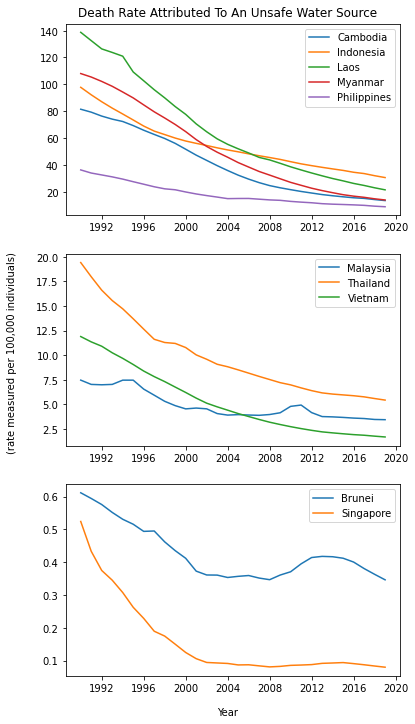

In [ ]:
plt.rcParams["figure.figsize"] = [6, 12]
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle("Death Rate Attributed To An Unsafe Water Source", y=0.9)
fig.text(0.5, 0.08, 'Year', ha='center')
fig.text(-0.01, 0.5, '(rate measured per 100,000 individuals)', va='center', rotation='vertical')

ax1.plot(newdata.Year, newdata.Cambodia, label='Cambodia')
ax1.plot(newdata.Year, newdata.Indonesia, label='Indonesia')
ax1.plot(newdata.Year, newdata.Laos, label='Laos')
ax1.plot(newdata.Year, newdata.Myanmar, label='Myanmar')
ax1.plot(newdata.Year, newdata.Philippines, label='Philippines')
ax1.legend()

ax2.plot(newdata.Year, newdata.Malaysia, label='Malaysia')
ax2.plot(newdata.Year, newdata.Thailand, label='Thailand')
ax2.plot(newdata.Year, newdata.Vietnam, label='Vietnam')
ax2.legend()

ax3.plot(newdata.Year, newdata.Brunei, label='Brunei')
ax3.plot(newdata.Year, newdata.Singapore, label='Singapore')
ax3.legend()

##Test all 4 models with all the countries (Validation)

In [ ]:
def modelCreation(dt):
  x_train = dt[dt['Year'] < '2014-01-01']
  x_train.set_index('Year', inplace=True)
  x_valid = dt[dt['Year'] >= '2014-01-01']
  x_valid.set_index('Year', inplace=True)
  index_6_years = pd.date_range(x_valid.index[0], freq='AS', periods=6)

  #arima (model 1)
  modelCreation.auto_arima_model = pm.auto_arima(x_train, seasonal=False, m=7)
  fcast1 = modelCreation.auto_arima_model.predict(6) 
  fcast1 = pd.Series(fcast1, index=index_6_years)
  fcast1 = fcast1.rename("ARIMA")

  ################################################################################

  #sarima (model 2)
  modelCreation.auto_sarima_model = pm.auto_arima(x_train, seasonal=True, m=7)
  fcast2 = modelCreation.auto_sarima_model.predict(6) 
  fcast2 = pd.Series(fcast2, index=index_6_years)
  fcast2 = fcast2.rename("SARIMA")

  ################################################################################

  #prophet (model 3)
  # prepare expected column names
  x_train1 = dt[dt['Year'] < '2014-01-01']
  x_train1.columns = ['ds', 'y']
  x_train1['ds']= to_datetime(x_train1['ds'])

  # define the model
  modelCreation.model = Prophet()
  # fit the model
  modelCreation.model.fit(x_train1)

  # define the period for which we want a prediction
  df_index_6_years = pd.DataFrame(index_6_years)
  df_index_6_years.columns = ['ds']
  df_index_6_years['ds']= to_datetime(df_index_6_years['ds'])

  # use the model to make a forecast
  fcast3 = modelCreation.model.predict(df_index_6_years)
  fcast3 = pd.Series(fcast3['yhat'].values, index=index_6_years)
  fcast3 = fcast3.rename("Prophet")

  ################################################################################

  #AR (model 4)
  modelCreation.auto_regression_model = AutoReg(x_train.iloc[:,0], lags=10).fit()
  fcast4 = modelCreation.auto_regression_model.predict(start=datetime(2014,1,1), end=datetime(2019,1,1), dynamic=False) 
  fcast4 = fcast4.rename("AR")

  ################################################################################

  print('The RMSE of ARIMA is:', mean_squared_error(x_valid.iloc[:,0].values, fcast1.values, squared=False))
  print('The RMSE of SARIMA is:', mean_squared_error(x_valid.iloc[:,0].values, fcast2.values, squared=False))
  print('The RMSE of Prophet is:', mean_squared_error(x_valid.iloc[:,0].values, fcast3.values, squared=False))
  print('The RMSE of AR is:', mean_squared_error(x_valid.iloc[:,0].values, fcast4.values, squared=False))

  fig, ax = plt.subplots(figsize=(15,5))
  plt.plot(newdata.Year, dt.iloc[:,1])
  fcast1.plot(ax=ax, color='red', marker="o", legend=True)
  fcast2.plot(ax=ax, color='cyan', marker="o", legend=True)
  fcast3.plot(ax=ax, color='green', marker="o", legend=True)
  fcast4.plot(ax=ax, color='orange', marker="o", legend=True)
  x_valid.plot(ax=ax, color='blue', marker="o", legend=True)

#Prediction


In [ ]:
year = pd.DataFrame([['2020']], columns = ['Year'])
year['Year'] = year['Year'].astype(str) + '-01-01'
year['Year'] = pd.to_datetime(year['Year'])
year.set_index('Year', inplace=True)
year2050 = pd.date_range(year.index[0], freq='AS', periods=31)
df_year2050 = pd.DataFrame(year2050)
df_year2050.columns = ['ds']
df_year2050['ds']= to_datetime(df_year2050['ds'])

The RMSE of ARIMA is: 0.07909452058156599
The RMSE of SARIMA is: 0.09689511263198089
The RMSE of Prophet is: 0.10306338907789042
The RMSE of AR is: 0.06891135720628898


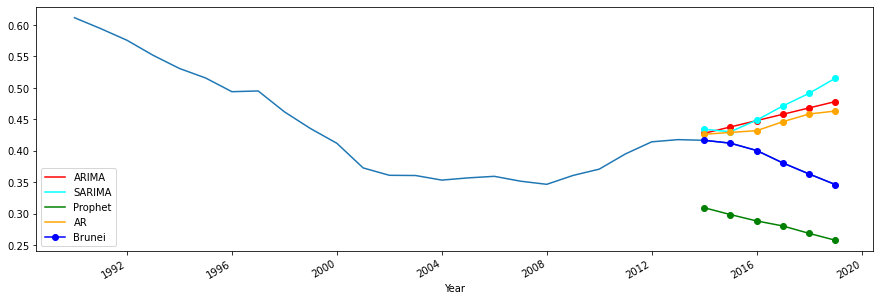

In [ ]:
#Brunei (Prophet)
dt = newdata[['Year', 'Brunei']]
modelCreation(dt)
brunei = modelCreation.model.predict(df_year2050)
brunei = pd.Series(brunei['yhat'].values, index=year2050)
for x in range(0, 31):
  finaldata['Brunei'].iloc[(x+30)] = brunei.iloc[x]

The RMSE of ARIMA is: 3.9222095681905786
The RMSE of SARIMA is: 3.9222095681905786
The RMSE of Prophet is: 2.3926334234924447
The RMSE of AR is: 2.9110903803279564


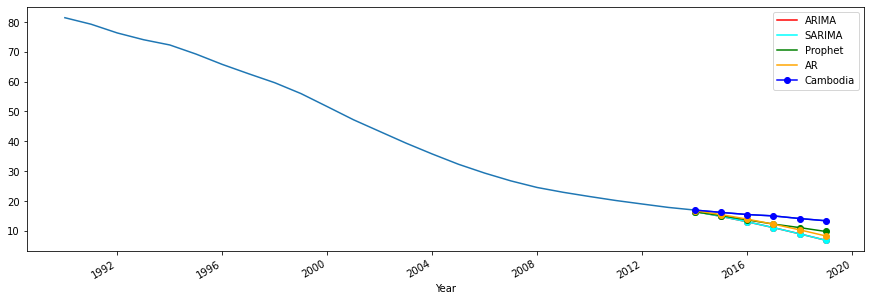

In [ ]:
#Cambodia (Prophet)
dt = newdata[['Year', 'Cambodia']]
modelCreation(dt)
cambodia = modelCreation.model.predict(df_year2050)
cambodia = pd.Series(cambodia['yhat'].values, index=year2050)
for x in range(0, 31):
  finaldata['Cambodia'].iloc[(x+30)] = cambodia.iloc[x]

The RMSE of ARIMA is: 2.0017251437390047
The RMSE of SARIMA is: 1.4003515781169196
The RMSE of Prophet is: 1.2817901039243706
The RMSE of AR is: 2.40498029872591


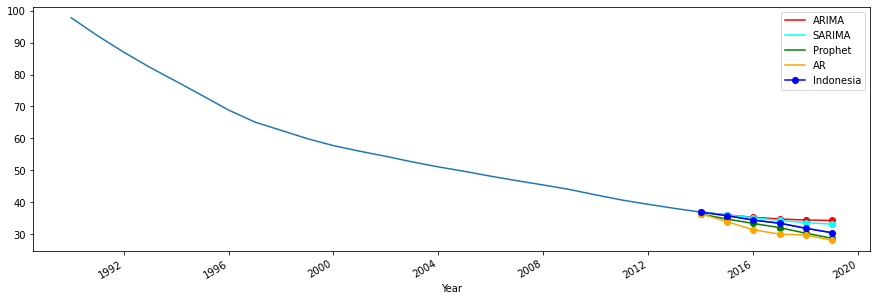

In [ ]:
#Indonesia (Prophet)
dt = newdata[['Year', 'Indonesia']]
modelCreation(dt)
indonesia = modelCreation.model.predict(df_year2050)
indonesia = pd.Series(indonesia['yhat'].values, index=year2050)
for x in range(0, 31):
  finaldata['Indonesia'].iloc[(x+30)] = indonesia.iloc[x]

The RMSE of ARIMA is: 1.3354696843969993
The RMSE of SARIMA is: 2.18837792485347
The RMSE of Prophet is: 3.168994617578205
The RMSE of AR is: 1.140519134672912


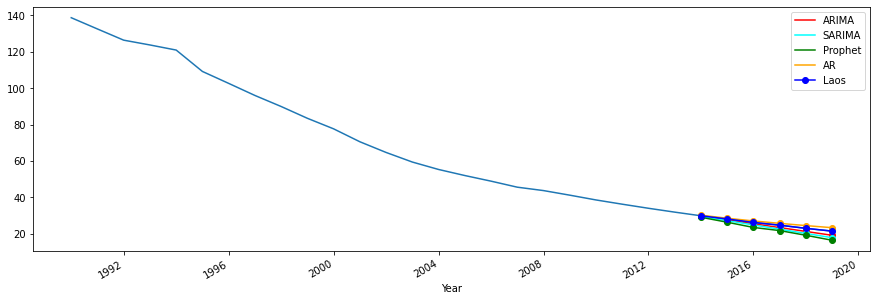

In [ ]:
#Laos (AR)
dt = newdata[['Year', 'Laos']]
modelCreation(dt)
laos = modelCreation.auto_regression_model.predict(start=datetime(2020,1,1), end=datetime(2050,1,1), dynamic=False) 
for x in range(0, 31):
  finaldata['Laos'].iloc[(x+30)] = laos.iloc[x]

The RMSE of ARIMA is: 0.36195413419830297
The RMSE of SARIMA is: 0.36195413419830297
The RMSE of Prophet is: 0.8493208150710073
The RMSE of AR is: 2.017272961271361


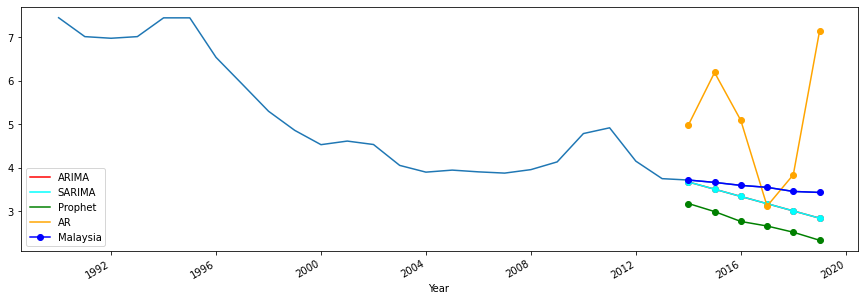

In [ ]:
#Malaysia (ARIMA)
dt = newdata[['Year', 'Malaysia']]
modelCreation(dt)
malaysia = modelCreation.auto_arima_model.predict(31) 
malaysia = pd.Series(malaysia, index=year2050)
for x in range(0, 31):
  finaldata['Malaysia'].iloc[(x+30)] = malaysia.iloc[x]

The RMSE of ARIMA is: 3.1358344792912844
The RMSE of SARIMA is: 3.1358344792912844
The RMSE of Prophet is: 4.604723480250399
The RMSE of AR is: 1.331525495071867


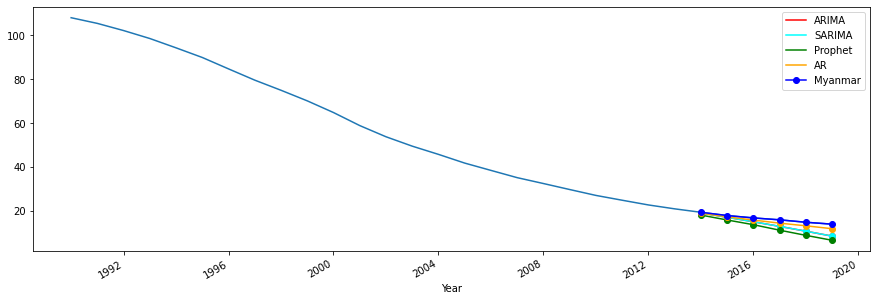

In [ ]:
#Myanmar (AR)
dt = newdata[['Year', 'Myanmar']]
modelCreation(dt)
myanmar = modelCreation.auto_regression_model.predict(start=datetime(2020,1,1), end=datetime(2050,1,1), dynamic=False) 
for x in range(0, 31):
  finaldata['Myanmar'].iloc[(x+30)] = myanmar.iloc[x]

The RMSE of ARIMA is: 1.2872829815252413
The RMSE of SARIMA is: 1.714247127646317
The RMSE of Prophet is: 0.5831685997135746
The RMSE of AR is: 0.7785847783582466


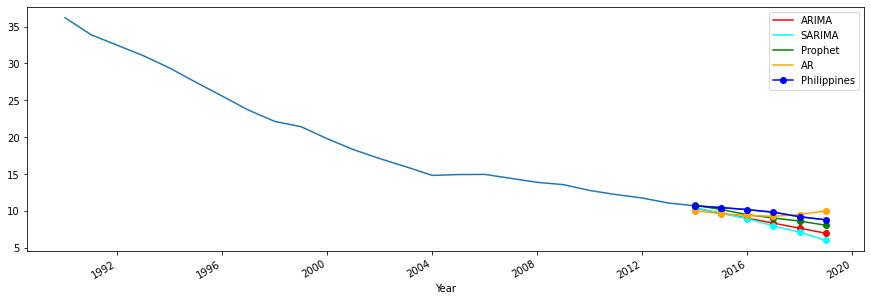

In [ ]:
#Philippines (Prophet)
dt = newdata[['Year', 'Philippines']]
modelCreation(dt)
philippines = modelCreation.model.predict(df_year2050)
philippines = pd.Series(philippines['yhat'].values, index=year2050)
for x in range(0, 31):
  finaldata['Philippines'].iloc[(x+30)] = philippines.iloc[x]

The RMSE of ARIMA is: 0.0704769524445593
The RMSE of SARIMA is: 0.09322577807278182
The RMSE of Prophet is: 0.14843755539284595
The RMSE of AR is: 0.006573699972915765


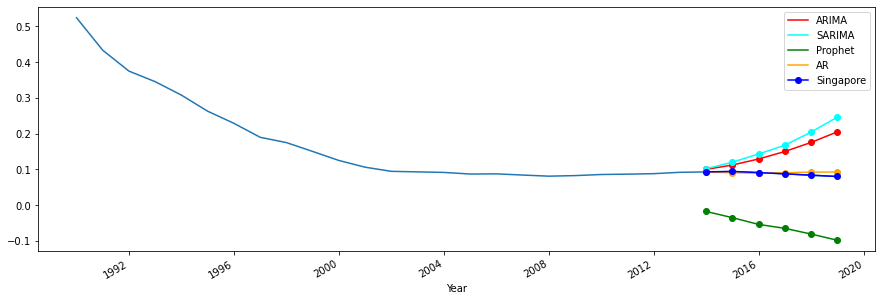

In [ ]:
#Singapore (AR)
dt = newdata[['Year', 'Singapore']]
modelCreation(dt)
singapore = modelCreation.auto_regression_model.predict(start=datetime(2020,1,1), end=datetime(2050,1,1), dynamic=False) 
for x in range(0, 31):
  finaldata['Singapore'].iloc[(x+30)] = singapore.iloc[x]

The RMSE of ARIMA is: 0.3283287385991632
The RMSE of SARIMA is: 0.4937554665412657
The RMSE of Prophet is: 0.6634183089834044
The RMSE of AR is: 0.36751965706127493


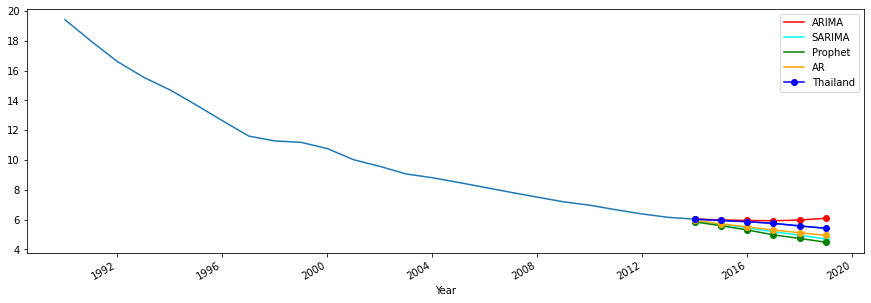

In [ ]:
#Thailand (AR)
dt = newdata[['Year', 'Thailand']]
modelCreation(dt)
thailand = modelCreation.auto_regression_model.predict(start=datetime(2020,1,1), end=datetime(2050,1,1), dynamic=False) 
for x in range(0, 31):
  finaldata['Thailand'].iloc[(x+30)] = thailand.iloc[x]

The RMSE of ARIMA is: 0.08260973103657424
The RMSE of SARIMA is: 0.08260973103657424
The RMSE of Prophet is: 0.4594536550465807
The RMSE of AR is: 0.1420582014030695


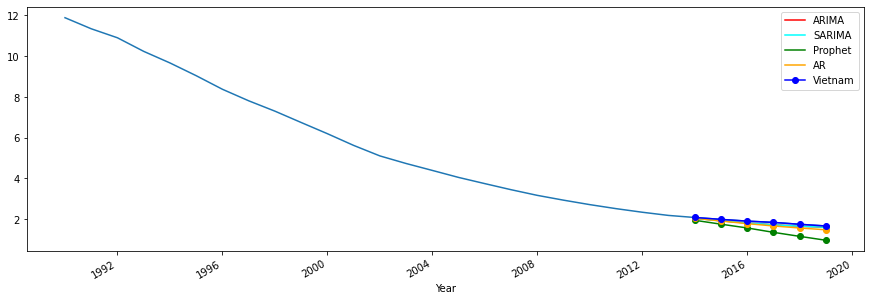

In [ ]:
#Vietnam (AR)
dt = newdata[['Year', 'Vietnam']]
modelCreation(dt)
vietnam = modelCreation.auto_regression_model.predict(start=datetime(2020,1,1), end=datetime(2050,1,1), dynamic=False) 
for x in range(0, 31):
  finaldata['Vietnam'].iloc[(x+30)] = vietnam.iloc[x]

In [ ]:
finaldata.iloc[:, 1:-1] = finaldata.iloc[:, 1:-1].clip(lower = 0)
finaldata.iloc[:, 1:-1] = finaldata.iloc[:, 1:-1].replace(0, np.nan)

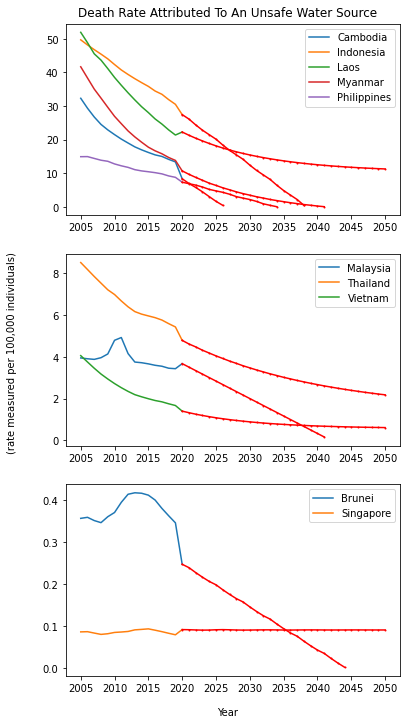

In [ ]:
plt.rcParams["figure.figsize"] = [6, 12]
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle("Death Rate Attributed To An Unsafe Water Source", y=0.9)
fig.text(0.5, 0.08, 'Year', ha='center')
fig.text(-0.01, 0.5, '(rate measured per 100,000 individuals)', va='center', rotation='vertical')

ax1.plot(finaldata['Year'].iloc[15:31], finaldata['Cambodia'].iloc[15:31], label='Cambodia')
ax1.plot(finaldata['Year'].iloc[30:62], finaldata['Cambodia'].iloc[30:62], color='red', marker="o", markersize=1)
ax1.plot(finaldata['Year'].iloc[15:31], finaldata['Indonesia'].iloc[15:31], label='Indonesia')
ax1.plot(finaldata['Year'].iloc[30:62], finaldata['Indonesia'].iloc[30:62], color='red', marker="o", markersize=1)
ax1.plot(finaldata['Year'].iloc[15:31], finaldata['Laos'].iloc[15:31], label='Laos')
ax1.plot(finaldata['Year'].iloc[30:62], finaldata['Laos'].iloc[30:62], color='red', marker="o", markersize=1)
ax1.plot(finaldata['Year'].iloc[15:31], finaldata['Myanmar'].iloc[15:31], label='Myanmar')
ax1.plot(finaldata['Year'].iloc[30:62], finaldata['Myanmar'].iloc[30:62], color='red', marker="o", markersize=1)
ax1.plot(finaldata['Year'].iloc[15:31], finaldata['Philippines'].iloc[15:31], label='Philippines')
ax1.plot(finaldata['Year'].iloc[30:62], finaldata['Philippines'].iloc[30:62], color='red', marker="o", markersize=1)
ax1.legend()

ax2.plot(finaldata['Year'].iloc[15:31], finaldata['Malaysia'].iloc[15:31], label='Malaysia')
ax2.plot(finaldata['Year'].iloc[30:62], finaldata['Malaysia'].iloc[30:62], color='red', marker="o", markersize=1)
ax2.plot(finaldata['Year'].iloc[15:31], finaldata['Thailand'].iloc[15:31], label='Thailand')
ax2.plot(finaldata['Year'].iloc[30:62], finaldata['Thailand'].iloc[30:62], color='red', marker="o", markersize=1)
ax2.plot(finaldata['Year'].iloc[15:31], finaldata['Vietnam'].iloc[15:31], label='Vietnam')
ax2.plot(finaldata['Year'].iloc[30:62], finaldata['Vietnam'].iloc[30:62], color='red', marker="o", markersize=1)
ax2.legend()

ax3.plot(finaldata['Year'].iloc[15:31], finaldata['Brunei'].iloc[15:31], label='Brunei')
ax3.plot(finaldata['Year'].iloc[30:62], finaldata['Brunei'].iloc[30:62], color='red', marker="o", markersize=1)
ax3.plot(finaldata['Year'].iloc[15:31], finaldata['Singapore'].iloc[15:31], label='Singapore')
ax3.plot(finaldata['Year'].iloc[30:62], finaldata['Singapore'].iloc[30:62], color='red', marker="o", markersize=1)
ax3.legend()